# Milestone 2

In [78]:
import math
import pickle
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from multiprocessing import Pool
from lxml import etree as ET
import os
import gzip

In [3]:
data_folder = 'data/'
pickle_folder = data_folder + 'pickles/'
cmu_folder = data_folder + 'MovieSummaries/'
imdb_folder = data_folder + 'IMDB/'
quickload_folder = data_folder + 'quickload/'

## Completing and cleaning the movie dataset
We will use Wikidata and IMDB databases in order to complete and cross-check the movie table from the CMU dataset.

### Getting the Wikidata IDs

In [9]:
# Partie de Gui

### Merging with Wikidata

In [10]:
movies_with_wikidata_id = pickle.load(open(pickle_folder + 'movies_with_wikidata_id.p', 'rb'))
unique_movie_ids = movies_with_wikidata_id.wikidata_id.unique()

In [24]:
def get_runtime(runtime):
    if runtime['unit'] == 'http://www.wikidata.org/entity/Q7727':
        return int(runtime['amount'].replace('+', ''))
    elif runtime['unit'] == 'http://www.wikidata.org/entity/Q11574':
        return int(runtime['amount'].replace('+', ''))/60
    elif runtime['unit'] == 'http://www.wikidata.org/entity/Q25235':
        return int(runtime['amount'].replace('+', '')) * 60
    else:
        return np.nan

def get_release_date(date):
    try:
        return date['time'].removeprefix('+').removesuffix('T00:00:00Z').replace('-00-00','').replace('-00','')
    except:
        return np.nan

def get_wikidata_info(id):
    wanted_properties = ['P577', # release date
                       'P444', # review score
                       'P2142', # box office revenue
                       'P646',  # freebase ID
                       'P345',  # IMDB ID
                       'P2047', # runtime
                       'P1237', # boxoffice Mojo ID
                       ]

    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        features = dict()
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        features['new_wikidata_id'] = key
        for prop in wanted_properties:
            try:
                element = json_id['entities'][key]['claims'][prop][0]['mainsnak']['datavalue']['value']
                if prop == 'P2047':
                    features[prop] = get_runtime(element)
                elif prop == 'P577':
                    features[prop] = get_release_date(element)
                else:
                    features[prop] = element
            except:
                pass

        if len(features) == 0:
            features = np.nan
        return [id, features]
    else:
        return [id, np.nan]

In [ ]:
total_len = len(unique_movie_ids)

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata_info, unique_movie_ids), total=total_len, smoothing=0.0))

pickle.dump(collection, open(f'{quickload_folder}movie_wikidata_collection.p','wb'))

In [29]:
def get_feature(x, feature, fct=(lambda y: y)):
    try:
        return fct(x[feature])
    except:
        return np.nan

def to_int(x):
    try:
        return int(x)
    except:
        return np.nan


movies_wd = pd.DataFrame(collection)

movies_wd['new_wikidata_id'] = movies_wd[1].apply(lambda x: get_feature(x, 'new_wikidata_id'))
movies_wd['box_office_wd']   = movies_wd[1].apply(lambda x: get_feature(x, 'P2142', lambda y: int(y['amount'].removeprefix('+'))))
movies_wd['ratings_wd']      = movies_wd[1].apply(lambda x: get_feature(x, 'P444'))
movies_wd['freebase_id_wd']  = movies_wd[1].apply(lambda x: get_feature(x, 'P646'))
movies_wd['IMDB_id']         = movies_wd[1].apply(lambda x: get_feature(x, 'P345'))
movies_wd['mojo_id']         = movies_wd[1].apply(lambda x: get_feature(x, 'P1237'))
movies_wd['runtime_wd']      = movies_wd[1].apply(lambda x: get_feature(x, 'P2047', to_int))
movies_wd['release_date_wd'] = pd.to_datetime(movies_wd[1].apply(lambda x: get_feature(x, 'P577')), errors='ignore')

movies_wd = movies_wd.drop(labels=[1], axis=1)

movies_wd.head()

,0,new_wikidata_id,box_office_wd,ratings_wd,freebase_id_wd,IMDB_id,mojo_id,runtime_wd,release_date_wd
0,Q261700,Q261700,NaN,22%,/m/03vyhn,tt0228333,ghostsofmars,94.0,2001-01-01
1,Q16250726,Q16250726,NaN,NaN,/m/08yl5d,tt0245916,NaN,NaN,2000-01-01
2,Q4978832,Q4978832,NaN,NaN,/m/0crgdbh,tt0094806,NaN,NaN,1988-01-01
3,Q7995657,Q7995657,NaN,50%,/m/0285_cd,tt0094320,NaN,NaN,1987-01-01
4,Q869644,Q869644,NaN,NaN,/m/01mrr1,tt0083949,NaN,106.0,1983-01-01


In [32]:
movies = pd.merge(left=movies_with_wikidata_id, right=movies_wd, left_on='wikidata_id', right_on=0, how='left').drop(0,axis=1)
movies.head()

,Wikipedia ID,freebase_id,wikidata_id,name,release date,box office revenue,runtime,languages,countries,genres,new_wikidata_id,box_office_wd,ratings_wd,freebase_id_wd,IMDB_id,mojo_id,runtime_wd,release_date_wd
0,975900,/m/03vyhn,Q261700,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,NaN,22%,/m/03vyhn,tt0228333,ghostsofmars,94.0,2001-01-01
1,3196793,/m/08yl5d,Q16250726,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Q16250726,NaN,NaN,/m/08yl5d,tt0245916,NaN,NaN,2000-01-01
2,28463795,/m/0crgdbh,Q4978832,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Q4978832,NaN,NaN,/m/0crgdbh,tt0094806,NaN,NaN,1988-01-01
3,9363483,/m/0285_cd,Q7995657,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",Q7995657,NaN,50%,/m/0285_cd,tt0094320,NaN,NaN,1987-01-01
4,261236,/m/01mrr1,Q869644,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Q869644,NaN,NaN,/m/01mrr1,tt0083949,NaN,106.0,1983-01-01


In [33]:
pickle.dump(movies, open(quickload_folder + 'movie_cmu_wd.p','wb'))

### Merging with IMDB
#### IMDB ratings

In [38]:
imdb_ratings = pd.read_csv(imdb_folder + 'title.ratings.tsv', sep='\t').rename({'averageRating': 'ratings_imdb', 'numVotes': 'numVotes_imdb'}, axis=1)
imdb_ratings.head()

,tconst,ratings_imdb,numVotes_imdb
0,tt0000001,5.7,1917
1,tt0000002,5.8,260
2,tt0000003,6.5,1725
3,tt0000004,5.6,173
4,tt0000005,6.2,2541


In [40]:
movies = pd.merge(left=movies, right=imdb_ratings, left_on='IMDB_id', right_on='tconst', how='left').drop(['tconst'], axis=1)
movies.head()

,Wikipedia ID,freebase_id,wikidata_id,name,release date,box office revenue,runtime,languages,countries,genres,new_wikidata_id,box_office_wd,ratings_wd,freebase_id_wd,IMDB_id,mojo_id,runtime_wd,release_date_wd,ratings_imdb,numVotes_imdb
0,975900,/m/03vyhn,Q261700,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,NaN,22%,/m/03vyhn,tt0228333,ghostsofmars,94.0,2001-01-01,4.9,55061.0
1,3196793,/m/08yl5d,Q16250726,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Q16250726,NaN,NaN,/m/08yl5d,tt0245916,NaN,NaN,2000-01-01,5.9,66.0
2,28463795,/m/0crgdbh,Q4978832,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Q4978832,NaN,NaN,/m/0crgdbh,tt0094806,NaN,NaN,1988-01-01,5.7,40.0
3,9363483,/m/0285_cd,Q7995657,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",Q7995657,NaN,50%,/m/0285_cd,tt0094320,NaN,NaN,1987-01-01,6.1,2537.0
4,261236,/m/01mrr1,Q869644,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Q869644,NaN,NaN,/m/01mrr1,tt0083949,NaN,106.0,1983-01-01,6.0,587.0


#### IMDB basics

In [42]:
imdb_basics = pd.read_csv(imdb_folder + 'title.basics.tsv', sep='\t').rename({'startYear': 'release_date_imdb', 'runtimeMinutes': 'runtime_imdb', 'genres': 'genres_imdb'}, axis=1)
imdb_basics.drop(labels= ['titleType', 'isAdult', 'endYear'], axis=1, inplace=True)
imdb_basics.head()

/tmp/ipykernel_10011/1646290345.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_basics = pd.read_csv(imdb_folder + 'title.basics.tsv', sep='\t').rename({'startYear': 'release_date_imdb', 'runtimeMinutes': 'runtime_imdb', 'genres': 'genres_imdb'}, axis=1)


,tconst,primaryTitle,originalTitle,release_date_imdb,runtime_imdb,genres_imdb
0,tt0000001,Carmencita,Carmencita,1894,1,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,1892,5,"Animation,Short"
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,1892,4,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,Un bon bock,1892,12,"Animation,Short"
4,tt0000005,Blacksmith Scene,Blacksmith Scene,1893,1,"Comedy,Short"


In [44]:
movies = pd.merge(left=movies, right=imdb_basics, left_on='IMDB_id', right_on='tconst', how='left').drop('tconst', axis=1)
movies.head()

,Wikipedia ID,freebase_id,wikidata_id,name,release date,box office revenue,runtime,languages,countries,genres,...,mojo_id,runtime_wd,release_date_wd,ratings_imdb,numVotes_imdb,primaryTitle,originalTitle,release_date_imdb,runtime_imdb,genres_imdb
0,975900,/m/03vyhn,Q261700,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",...,ghostsofmars,94.0,2001-01-01,4.9,55061.0,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi"
1,3196793,/m/08yl5d,Q16250726,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",...,NaN,NaN,2000-01-01,5.9,66.0,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,2000,95,Drama
2,28463795,/m/0crgdbh,Q4978832,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",...,NaN,NaN,1988-01-01,5.7,40.0,Brun bitter,Brun bitter,1988,83,"Crime,Drama"
3,9363483,/m/0285_cd,Q7995657,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",...,NaN,NaN,1987-01-01,6.1,2537.0,White of the Eye,White of the Eye,1987,110,"Horror,Thriller"
4,261236,/m/01mrr1,Q869644,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",...,NaN,106.0,1983-01-01,6.0,587.0,A Woman in Flames,Die flambierte Frau,1983,106,Drama


#### IMDB Directors & crew

In [46]:
crew = pd.read_csv(imdb_folder + 'title.crew.tsv', sep='\t')
crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [47]:
movies = pd.merge(movies, crew, left_on='IMDB_id', right_on='tconst', how='left').drop(labels=['tconst'], axis=1)
movies.head()

,Wikipedia ID,freebase_id,wikidata_id,name,release date,box office revenue,runtime,languages,countries,genres,...,release_date_wd,ratings_imdb,numVotes_imdb,primaryTitle,originalTitle,release_date_imdb,runtime_imdb,genres_imdb,directors,writers
0,975900,/m/03vyhn,Q261700,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",...,2001-01-01,4.9,55061.0,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",nm0000118,"nm0837917,nm0000118"
1,3196793,/m/08yl5d,Q16250726,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",...,2000-01-01,5.9,66.0,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,2000,95,Drama,nm1740285,"nm0334224,nm0003358"
2,28463795,/m/0crgdbh,Q4978832,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",...,1988-01-01,5.7,40.0,Brun bitter,Brun bitter,1988,83,"Crime,Drama",nm0803751,"nm0803751,nm0820866"
3,9363483,/m/0285_cd,Q7995657,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",...,1987-01-01,6.1,2537.0,White of the Eye,White of the Eye,1987,110,"Horror,Thriller",nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
4,261236,/m/01mrr1,Q869644,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",...,1983-01-01,6.0,587.0,A Woman in Flames,Die flambierte Frau,1983,106,Drama,nm0885554,"nm0885554,nm0959016"


In [48]:
pickle.dump(movies, open(quickload_folder + 'movies_wd_imdb.p', 'wb'))

### Merging and Cross-checking
#### Ratings
Wikidata ratings come from multiple sources, whereas IMDB ratings are homogeneous. Are wikidata ratings more complete?

In [50]:
print(f'Number of movies with Wikidata ratings but without IMDB ratings: {len(movies.loc[movies.ratings_wd.notna() & movies.ratings_imdb.isna()])}')

Number of movies with Wikidata ratings but without IMDB ratings: 27


Only 27 movies: we can drop the Wikidata ratings

In [51]:
movies.drop(labels='ratings_wd',axis=1, inplace=True)

#### Release year
Let's simplify by only looking at the year.
We have three sources for the release year: the CMU dataset, wikidata and IMDB.
If two out of three sources have less than 5 years of difference, we keep one of them, otherwise we keep the original year if it's not null, otherwise the IMDB year, or else the Wikidata year.

In [55]:
def get_year(x):
    try:
        if isinstance(x, int):
            return x
        else:
            return pd.to_datetime(x, errors='ignore').year
    except:
        return np.nan
movies['release_year_cmu'] = movies['release date'].apply(lambda x: get_year(x))
movies['release_year_wd'] = movies['release_date_wd'].apply(lambda x: get_year(x))
movies['release_year_imdb'] = movies['release_date_imdb'].apply(lambda x: get_year(x))
movies[['release_year_cmu', 'release_year_imdb', 'release_year_wd']].head()

,release_year_cmu,release_year_imdb,release_year_wd
0,2001.0,2001.0,2001.0
1,2000.0,2000.0,2000.0
2,1988.0,1988.0,1988.0
3,1987.0,1987.0,1987.0
4,1983.0,1983.0,1983.0


In [56]:
def three_way_compare(x, y, z, limit):
    if abs(x - y) < limit:
        return x
    elif abs(x - z) < limit:
        return x
    elif abs(y - z) < limit:
        return y
    elif pd.notna(x):
        return x
    elif pd.notna(y):
        return y
    elif pd.notna(z):
        return z
    else:
        return np.nan

movies['combined_release_year'] = movies.apply(lambda x: three_way_compare(x['release_year_cmu'], x['release_year_imdb'], x['release_year_wd'], 5), axis=1)

#### Runtime
Here we also have runtime data from CMU, wikidata and IMDB.
We use the same logic as in the previous part, with a maximal difference of 10 minutes

In [59]:
movies['runtime_wd'] = movies.runtime_wd.apply(lambda x: to_int(x))
movies['runtime_imdb'] = movies.runtime_imdb.apply(lambda x: to_int(x))
movies['combined_runtime'] = movies.apply(lambda x: three_way_compare(x['runtime'], x['runtime_imdb'], x['runtime_wd'], 10), axis=1)

### Clean up the movie DataFrame

In [64]:
movies = movies[['name', 'Wikipedia ID', 'freebase_id', 'wikidata_id', 'IMDB_id', 'mojo_id',
                 'release_year_cmu', 'release_year_wd', 'release_year_imdb',
       'combined_release_year',
                 'runtime',  'runtime_wd', 'runtime_imdb', 'combined_runtime',
                 'box office revenue', 'box_office_wd', 'ratings_imdb', 'numVotes_imdb',
                 'languages', 'countries','genres', 'genres_imdb', 'directors', 'writers',
        ]]
movies = movies.rename({'name':'title', 'Wikipedia ID':'wikipedia_id', 'runtime':'runtime_cmu', 'box office revenue':'box_office_cmu', 'genres':'genres_cmu'})
movies.head()

,name,Wikipedia ID,freebase_id,wikidata_id,IMDB_id,mojo_id,release_year_cmu,release_year_wd,release_year_imdb,combined_release_year,...,box office revenue,box_office_wd,ratings_imdb,numVotes_imdb,languages,countries,genres,genres_imdb,directors,writers
0,Ghosts of Mars,975900,/m/03vyhn,Q261700,tt0228333,ghostsofmars,2001.0,2001.0,2001.0,2001.0,...,14010832.0,NaN,4.9,55061.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",nm0000118,"nm0837917,nm0000118"
1,Getting Away with Murder: The JonBenét Ramsey ...,3196793,/m/08yl5d,Q16250726,tt0245916,NaN,2000.0,2000.0,2000.0,2000.0,...,NaN,NaN,5.9,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Drama,nm1740285,"nm0334224,nm0003358"
2,Brun bitter,28463795,/m/0crgdbh,Q4978832,tt0094806,NaN,1988.0,1988.0,1988.0,1988.0,...,NaN,NaN,5.7,40.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",nm0803751,"nm0803751,nm0820866"
3,White Of The Eye,9363483,/m/0285_cd,Q7995657,tt0094320,NaN,1987.0,1987.0,1987.0,1987.0,...,NaN,NaN,6.1,2537.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","Horror,Thriller",nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
4,A Woman in Flames,261236,/m/01mrr1,Q869644,tt0083949,NaN,1983.0,1983.0,1983.0,1983.0,...,NaN,NaN,6.0,587.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,nm0885554,"nm0885554,nm0959016"


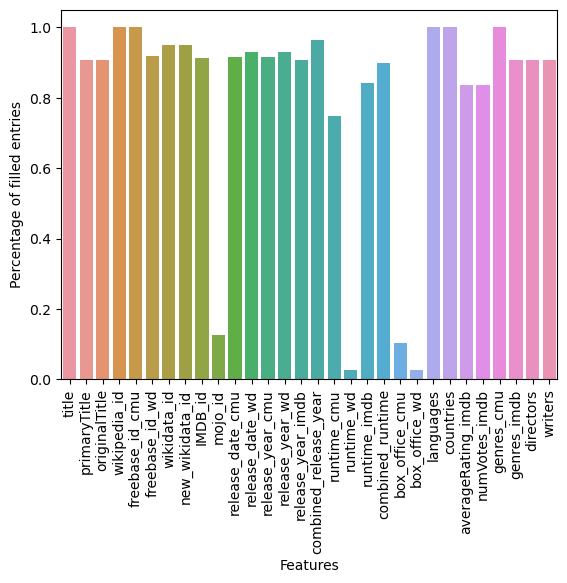

In [30]:
def plot_percentage_filled_entries(df):
    features = list(df.keys())
    tempdict = {}
    len_df = len(df)
    for feature in features:
       tempdict[feature] =  df[feature].notna().sum() / len_df

    tempdf = pd.DataFrame([tempdict])

    ax = sns.barplot(data=tempdf)
    ax.set_ylabel('Percentage of filled entries')
    ax.set_xlabel('Features')
    ax.tick_params('x', labelrotation=90)

plot_percentage_filled_entries(movies)

## Completing and cleaning the characters dataset
Just as in the movies table, we will use Wikidata and IMDB databases in order to complete and cross-check the characters table from the CMU dataset.

In [4]:
characters = pd.read_table(cmu_folder + 'character.metadata.tsv',names=['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu', 'character_name', 'birth_cmu', 'gender_cmu', 'height', 'ethnicity', 'actor_name', 'actor_age', 'freebase_character_actor_map_id', 'freebase_character_id', 'freebase_actor_id' ] , sep='\t', index_col=False)
characters['birth_cmu'] = pd.to_datetime(characters.birth_cmu, errors='ignore')

characters

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In order to query wikidata, we will use [this table](https://developers.google.com/freebase#freebase-wikidata-mappings) that maps freebase IDs to wikidata IDs. It has been preprocessed in order to make its use easier.

In [5]:
freebase_wd_mapping = pickle.load(open(pickle_folder + 'freebase_to_wikidata.p', 'rb'))
freebase_wd_mapping.head()

,freebase_id,wikidata_id
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


#### Get Actors information from Wikidata
We will query wikidata in order to retrieve information about actors, such as date of birth, gender

In [6]:
actors_freebase_wd_id = pd.merge(characters, freebase_wd_mapping, left_on='freebase_actor_id', right_on='freebase_id', how='left')[['freebase_actor_id', 'wikidata_id']]
unique_actors_wikidata_id = actors_freebase_wd_id.wikidata_id.unique()
unique_actors_wikidata_id[1:6]

array(['Q230527', 'Q173637', 'Q169963', 'Q233347', 'Q233862'],
      dtype=object)

In [85]:
def get_runtime(runtime):
    if runtime['unit'] == 'http://www.wikidata.org/entity/Q7727':
        return int(runtime['amount'].replace('+', ''))
    elif runtime['unit'] == 'http://www.wikidata.org/entity/Q11574':
        return int(runtime['amount'].replace('+', ''))/60
    elif runtime['unit'] == 'http://www.wikidata.org/entity/Q25235':
        return int(runtime['amount'].replace('+', '')) * 60
    else:
        return np.nan

def get_date(date):
    try:
        return date['time'].removeprefix('+').removesuffix('T00:00:00Z').replace('-00-00','').replace('-00','')
    except:
        return np.nan

def get_wikidata_info(id):
    wanted_properties = ['P21',   # gender
                       'P569',  # date of birth
                       'P172',  # ethnicity
                       'P800',  # notable movies
                       'P345',  # IMDB ID
                       ]

    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        features = dict()
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        for prop in wanted_properties:
            try:
                if prop == '800':
                    features[prop] = len(json_id['entities'][key]['claims']['P800'])
                else:
                    element = json_id['entities'][key]['claims'][prop][0]['mainsnak']['datavalue']['value']
                    if prop == 'P569':
                        features[prop] = get_date(element)
                    elif prop == 'P345':
                        features[prop] = element
                    else:
                        features[prop] = element['id']
            except:
                pass

        if len(features) == 0:
            features = np.nan
        return [id, features]
    else:
        return [id, np.nan]

In [88]:
total_len = len(unique_actors_wikidata_id)

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata_info, unique_actors_wikidata_id), total=total_len, smoothing=0.0))

pickle.dump(collection, open(f'{quickload_folder}actors_wikidata_collection.p','wb'))

100%|██████████| 35792/35792 [36:54<00:00, 16.16it/s]


In [7]:
collection = pickle.load(open(f'{quickload_folder}actors_wikidata_collection.p','rb'))

In [8]:
def get_year(x):
    try:
        return pd.to_datetime(x['P569']).year
    except:
        return np.nan

def get_feature(x, feature):
    try:
        return x[feature]
    except:
        return np.nan

actors_info = pd.DataFrame(collection).rename({0: 'wikidata_id'}, axis=1)

actors_info['birth_wd'] = actors_info[1].apply(lambda x: get_year(x))
actors_info['gender_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P21'))
actors_info['actor_imdb_id'] = actors_info[1].apply(lambda x: get_feature(x, 'P345'))
actors_info['number_notable_movies_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P800'))
actors_info['ethnicity_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P172'))
actors_info.drop(1, axis=1, inplace=True)
actors_info.head()

,wikidata_id,birth_wd,gender_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd
0,Q1873468,1958.0,Q6581072,nm0208962,NaN,NaN
1,Q230527,1974.0,Q6581072,nm0000449,NaN,NaN
2,Q173637,1969.0,Q6581097,nm0001084,NaN,NaN
3,Q169963,1967.0,Q6581097,nm0005458,NaN,NaN
4,Q233347,1977.0,Q6581072,nm0245112,NaN,NaN


In [9]:
characters = pd.merge(pd.merge(characters, freebase_wd_mapping, left_on='freebase_actor_id', right_on='freebase_id', how='left').drop('freebase_id',axis=1), actors_info, left_on='wikidata_id', right_on='wikidata_id', how='left')
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,wikidata_id,birth_wd,gender_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Q1873468,1958.0,Q6581072,nm0208962,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Q230527,1974.0,Q6581072,nm0000449,NaN,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q173637,1969.0,Q6581097,nm0001084,NaN,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Q169963,1967.0,Q6581097,nm0005458,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Q233347,1977.0,Q6581072,nm0245112,NaN,NaN


In [10]:
pickle.dump(characters, open(quickload_folder + 'characters_wd.p', 'wb'))

#### Get labels for Gender and Ethnicity
The gender and ethnicity information we requested from wikidata are encoded in wikidata_id. We have to get their label name from wikidata.

In [11]:
def get_wikidata(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        try:
            return  [id, json_id['entities'][key]['labels']['en']['value']]
        except:
            return [id, np.nan]
    else:
        return [id, np.nan]

In [12]:
genders = characters.gender_wd.unique()

total_len = len(genders)

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata, genders), total=total_len, smoothing=0.0))
pickle.dump(collection, open(quickload_folder + 'actors_gender_collection.p','wb'))

100%|██████████| 11/11 [00:01<00:00, 10.17it/s]


Let's have a look at the type of genders:

In [13]:
collection

[['Q6581072', 'female'],
 ['Q6581097', 'male'],
 [nan, nan],
 ['Q1052281', 'trans woman'],
 ['Q48270', 'non-binary'],
 ['Q18116794', 'genderfluid'],
 ['Q44148', 'male organism'],
 ['Q43445', 'female organism'],
 ['Q12964198', 'genderqueer'],
 ['Q2449503', 'trans man'],
 ['Q27679766', 'transmasculine']]

We should change **male organism** to **male** and **female organism** to **female**.

In [14]:
characters.loc[characters.gender_wd == 'Q44148', 'gender_wd'] = 'Q6581097'
characters.loc[characters.gender_wd == 'Q43445', 'gender_wd'] = 'Q6581072'

In [15]:
gender = pd.DataFrame(collection)
characters = pd.merge(characters, gender, left_on='gender_wd', right_on=0, how='left').drop(['gender_wd', 0], axis=1).rename({1:'gender_wd'}, axis=1)

In [16]:
characters.gender_wd.value_counts()

male              189609
female             94534
non-binary           109
genderfluid           77
trans woman           69
trans man              7
genderqueer            2
transmasculine         2
Name: gender_wd, dtype: int64

In [17]:
characters.gender_cmu.value_counts()

M    270257
F    134803
Name: gender_cmu, dtype: int64

Let's change F to female et M to male in order to have the same labels as in wikidata.

In [18]:
characters.loc[characters.gender_cmu == 'M', 'gender_cmu'] = 'male'
characters.loc[characters.gender_cmu == 'F', 'gender_cmu'] = 'female'

Now let's look at ethnicities.
We have cmu ethnicities in freebase_ids and wikidata ethnicities in wikidata_ids.
Let's change cmu freebases ids to wikidata ids then requests wikidata to get their labels

In [19]:
ethnicity_to_wd_id = pd.merge(characters[['ethnicity']], freebase_wd_mapping, left_on='ethnicity', right_on='freebase_id', how='left').drop('freebase_id', axis=1).dropna()
ethnicity_to_wd_id.head()

,ethnicity,wikidata_id
2,/m/0x67,Q49085
5,/m/0x67,Q49085
11,/m/064b9n,Q120601
27,/m/0x67,Q49085
55,/m/041rx,Q7325


Now we will take create a table [wikidata_id | ethnicity_label] with all unique ethnicities, both from CMU and wikidata.

In [20]:
unique_ethnicity_wd_id = pd.unique(np.concatenate([ethnicity_to_wd_id.wikidata_id.unique(), characters.ethnicity_wd.unique()]))

total_len = len(unique_ethnicity_wd_id)

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata, unique_ethnicity_wd_id), total=total_len, smoothing=0.0))
pickle.dump(collection, open(quickload_folder + 'actors_ethnicity_collection.p','wb'))

100%|██████████| 428/428 [00:23<00:00, 18.19it/s]


In [21]:
wd_to_ethnicity = pd.DataFrame(collection).rename({0:'wikidata_id_x', 1:'ethnicity_label'}, axis=1)
wd_to_ethnicity.head()

,wikidata_id_x,ethnicity_label
0,Q49085,African Americans
1,Q120601,Omaha people
2,Q7325,Jewish people
3,Q1075293,Irish Americans
4,Q2643509,Indian Americans


In [22]:
characters = pd.merge(characters, wd_to_ethnicity, left_on='ethnicity_wd', right_on='wikidata_id_x', how='left').drop(['wikidata_id_x', 'ethnicity_wd'], axis=1).rename({'ethnicity_label':'ethnicity_wd'}, axis=1)


In [37]:
freebase_to_ethnicity = pd.merge(pd.merge(characters, freebase_wd_mapping, left_on='ethnicity', right_on='freebase_id', how='left')[['ethnicity', 'wikidata_id_y']], wd_to_ethnicity, left_on='wikidata_id_y', right_on='wikidata_id_x', how='left')[['ethnicity', 'ethnicity_label']].drop_duplicates()
freebase_to_ethnicity.head()

,ethnicity,ethnicity_label
0,NaN,NaN
1,/m/044038p,NaN
2,/m/0x67,African Americans
11,/m/064b9n,Omaha people
55,/m/041rx,Jewish people


In [41]:
characters = pd.merge(characters, freebase_to_ethnicity, left_on='ethnicity', right_on='ethnicity', how='left').drop(['ethnicity'], axis=1).rename({'ethnicity_label':'ethnicity_cmu'}, axis=1)

### Merging with IMDB

In [51]:
imdb_characters = pd.read_csv(imdb_folder + 'name.basics.tsv', sep='\t').rename({'birthYear':'birth_imdb', 'deathYear':'death_imdb'}, axis=1)
imdb_characters.head()

,nconst,primaryName,birth_imdb,death_imdb,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0072308,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0072562,tt0077975,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0069467,tt0060827"


In [56]:
characters = pd.merge(characters, imdb_characters, left_on='actor_imdb_id', right_on='nconst', how='left').drop('nconst', axis=1)
characters['death_imdb'] = characters.death_imdb.apply(lambda x: np.nan if x == '\\N' else x)

characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,...,actor_imdb_id,number_notable_movies_wd,gender_wd,ethnicity_wd,ethnicity_cmu,primaryName,birth_imdb,death_imdb,primaryProfession,knownForTitles
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,...,nm0208962,NaN,female,NaN,NaN,Wanda De Jesus,1958,NaN,actress,"tt0100502,tt0140352,tt0228333,tt0309377"
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,...,nm0000449,NaN,female,NaN,NaN,Natasha Henstridge,1974,NaN,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508"
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,male,1.727,Ice Cube,32.0,/m/0jys3g,...,nm0001084,NaN,male,NaN,African Americans,Ice Cube,1969,NaN,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507"
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,male,1.750,Jason Statham,33.0,/m/02vchl6,...,nm0005458,NaN,male,NaN,NaN,Jason Statham,1967,NaN,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884"
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,female,1.650,Clea DuVall,23.0,/m/02vbb3r,...,nm0245112,NaN,female,NaN,NaN,Clea DuVall,1977,NaN,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648"


In [57]:
pickle.dump(characters, open(quickload_folder + 'charactes_wd_imdb.p', 'wb'))

### Merging and crosschecking sources
#### Date of birth
Here, just as we did for movies, we will crosscheck the three sources we have: CMU, wikidata and IMDB in order get a year of birth

In [11]:
characters = pickle.load( open(quickload_folder + 'charactes_wd_imdb.p', 'rb'))
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,...,actor_imdb_id,number_notable_movies_wd,gender_wd,ethnicity_wd,ethnicity_cmu,primaryName,birth_imdb,death_imdb,primaryProfession,knownForTitles
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,...,nm0208962,NaN,female,NaN,NaN,Wanda De Jesus,1958,NaN,actress,"tt0100502,tt0140352,tt0228333,tt0309377"
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,...,nm0000449,NaN,female,NaN,NaN,Natasha Henstridge,1974,NaN,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508"
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,male,1.727,Ice Cube,32.0,/m/0jys3g,...,nm0001084,NaN,male,NaN,African Americans,Ice Cube,1969,NaN,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507"
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,male,1.750,Jason Statham,33.0,/m/02vchl6,...,nm0005458,NaN,male,NaN,NaN,Jason Statham,1967,NaN,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884"
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,female,1.650,Clea DuVall,23.0,/m/02vbb3r,...,nm0245112,NaN,female,NaN,NaN,Clea DuVall,1977,NaN,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648"


In [14]:
characters['birth_imdb'] = characters.birth_imdb.apply(lambda x: to_int(x))
characters['birth_cmu'] = characters.birth_imdb.apply(lambda x: get_year(x))
characters['combined_birth'] = characters.apply(lambda x: three_way_compare(x['birth_imdb'], x['birth_wd'], x['birth_cmu'], limit=10), axis=1)
characters[['birth_cmu', 'birth_wd', 'birth_imdb', 'combined_birth']].head()

,birth_cmu,birth_wd,birth_imdb,combined_birth
0,1970.0,1958.0,1958.0,1958.0
1,1970.0,1974.0,1974.0,1974.0
2,1970.0,1969.0,1969.0,1969.0
3,1970.0,1967.0,1967.0,1967.0
4,1970.0,1977.0,1977.0,1977.0


#### Ethnicity

In [16]:
characters.loc[(characters.ethnicity_cmu != characters.ethnicity_wd) & (characters.ethnicity_cmu.notna() &  characters.ethnicity_wd.notna())][['ethnicity_cmu', 'ethnicity_wd']]

,ethnicity_cmu,ethnicity_wd
280,Scottish American,English American
288,Italian Americans,African Americans
554,German Americans,Americans
574,Indians,Marathi people
833,Asian Americans,Japanese American
...,...,...
449831,Sri Lankan Tamils,Malayali
449982,Sri Lankan Tamils,Malayali
450126,Asian Americans,Japanese American
450382,Sri Lankan Tamils,Malayali


It seems really hard to know which one is better than the other one. We decided to keep by default the CMU ethnicity, and we use the Wikidata ethnicity in order to fill the missing entries

In [18]:
characters['combined_ethnicity'] = characters.apply(lambda x: x['ethnicity_cmu'] if pd.notna(x['ethnicity_cmu']) else x['ethnicity_wd'], axis=1)
characters[['actor_name', 'ethnicity_cmu', 'ethnicity_wd', 'combined_ethnicity']].head()

,actor_name,ethnicity_cmu,ethnicity_wd,combined_ethnicity
0,Wanda De Jesus,NaN,NaN,NaN
1,Natasha Henstridge,NaN,NaN,NaN
2,Ice Cube,African Americans,NaN,African Americans
3,Jason Statham,NaN,NaN,NaN
4,Clea DuVall,NaN,NaN,NaN


#### Gender
As we have seen, Wikidata seems to have a less binary representation of gender, so we decided to keep wikidata gender by default, using CMU gender to feel the missing entries

In [25]:
characters['combined_gender'] = characters.apply(lambda x: x['gender_wd'] if pd.notna(x['gender_wd']) else x['gender_cmu'], axis=1)
characters[['gender_cmu', 'gender_wd', 'combined_gender']].head()

,gender_cmu,gender_wd,combined_gender
0,female,female,female
1,female,female,female
2,male,male,male
3,male,male,male
4,female,female,female


#### Movie release date from movies table
Let's replace the original movie release date by the one we found when combining CMU, Wikidata and IMDB

In [20]:
movies = pickle.load(open(pickle_folder + 'movies.p', 'rb'))

In [22]:
characters = pd.merge(characters, movies[['freebase_id_cmu', 'combined_release_year']], left_on='movie_freebase_id', right_on='freebase_id_cmu', how='left').drop('freebase_id_cmu', axis=1)

In [72]:
characters['release_date_cmu'] = characters.release_date_cmu.apply(lambda x: get_year(x)).astype(pd.Int32Dtype())

### Clean up of the characters table

In [69]:
characters = characters[['movie_wiki_id', 'movie_freebase_id','release_date_cmu',  'combined_release_year',
                         'character_name', 'actor_name', 'height',
                         'birth_cmu', 'birth_wd', 'birth_imdb', 'combined_birth', 'death_imdb',
                         'gender_cmu', 'gender_wd', 'combined_gender',
                         'ethnicity_cmu', 'ethnicity_wd','combined_ethnicity',
                         'freebase_character_id',
                         'freebase_actor_id', 'wikidata_id', 'actor_imdb_id',
                        ]]

characters = characters.rename({'wikidata_id': 'wikidata_actor_id'}, axis=1)

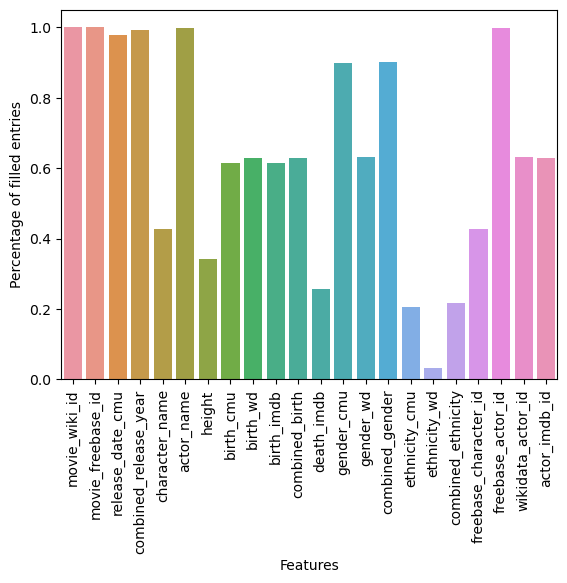

In [73]:
plot_percentage_filled_entries(characters)

In [ ]:
characters['combined_release_year'] = characters.combined_release_year.astype(pd.Int32Dtype())
characters['birth_cmu'] = characters.birth_cmu.astype(pd.Int32Dtype())
characters['birth_imdb'] = characters.birth_imdb.astype(pd.Int32Dtype())
characters['birth_wd'] = characters.birth_wd.astype(pd.Int32Dtype())
characters['combined_birth'] = characters.combined_birth.astype(pd.Int32Dtype())
characters['death_imdb'] = characters.death_imdb.astype(pd.Int32Dtype())

In [74]:
pickle.dump(characters, open(pickle_folder + 'characters.p', 'wb'))

In [5]:
characters

,movie_wiki_id,movie_freebase_id,release_date_cmu,combined_release_year,character_name,actor_name,height,birth_cmu,birth_wd,birth_imdb,...,gender_cmu,gender_wd,combined_gender,ethnicity_cmu,ethnicity_wd,combined_ethnicity,freebase_character_id,freebase_actor_id,wikidata_actor_id,actor_imdb_id
0,975900,/m/03vyhn,2001,2001,Akooshay,Wanda De Jesus,1.620,1970,1958,1958,...,female,female,female,NaN,NaN,NaN,/m/0bgcj3x,/m/03wcfv7,Q1873468,nm0208962
1,975900,/m/03vyhn,2001,2001,Lieutenant Melanie Ballard,Natasha Henstridge,1.780,1970,1974,1974,...,female,female,female,NaN,NaN,NaN,/m/0bgchn4,/m/0346l4,Q230527,nm0000449
2,975900,/m/03vyhn,2001,2001,Desolation Williams,Ice Cube,1.727,1970,1969,1969,...,male,male,male,African Americans,NaN,African Americans,/m/0bgchn_,/m/01vw26l,Q173637,nm0001084
3,975900,/m/03vyhn,2001,2001,Sgt Jericho Butler,Jason Statham,1.750,1970,1967,1967,...,male,male,male,NaN,NaN,NaN,/m/0bgchnq,/m/034hyc,Q169963,nm0005458
4,975900,/m/03vyhn,2001,2001,Bashira Kincaid,Clea DuVall,1.650,1970,1977,1977,...,female,female,female,NaN,NaN,NaN,/m/0bgchp9,/m/01y9xg,Q233347,nm0245112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992,1992,Elensh,Dorothy Elias-Fahn,NaN,1970,1962,1962,...,female,female,female,NaN,NaN,NaN,/m/0kr406h,/m/0b_vcv,Q5298405,nm0253528
450665,913762,/m/03pcrp,1992,1992,Hibiki,Jonathan Fahn,NaN,1970,1965,1965,...,male,male,male,NaN,NaN,NaN,/m/0kr4090,/m/0bx7_j,Q3809919,nm0153068
450666,28308153,/m/0cp05t9,1957,1957,NaN,David Hemmings,1.730,<NA>,<NA>,<NA>,...,male,NaN,male,English people,NaN,English people,NaN,/m/022g44,NaN,NaN
450667,28308153,/m/0cp05t9,1957,1957,NaN,Roberta Paterson,NaN,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/m/0g8ngmm,NaN,NaN


## Creating a Dataset with Director Data

To conduct an analysis on how females are represented in the writing of movies data was queried from WikiData Query Service to come up with a dataset containing biometric information on directors and screenwriters.


### Querying WikiData

The following query was run on WikiData Query Service to pull information on all Directors, Film Directors, and Screenwriters. Shown for Film Directors

In [ ]:
'''
# Sample to query all values of a property
SELECT Distinct
  ?filmDirector
  ?gender
  ?dob
  ?height
  ?place_of_birth
  ?ethnic_group
  ?citizenship
  ?eye_colour
  ?hair_colour
# valueLabel is only useful for properties with item-datatype
WHERE 
{
  ?filmDirector p:P106 ?statement1.
        ?statement1 (ps:P106/(wdt:P279*)) wd:Q2526255. #Find all items with a particular profession
  optional{?filmDirector wdt:P21 ?gender.}
  optional{?filmDirector wdt:P569 ?dob.}
  optional{?filmDirector wdt:P2048 ?height}
  optional{?filmDirector wdt:P172 ?ethnic_group}
  optional{?filmDirector wdt:P19 ?place_of_birth}
  optional{?filmDirector wdt:P27 ?citizenship}
  optional{?filmDirector wdt:P1340 ?eye_colour}
  optional{?filmDirector wdt:P1884 ?hair_colour}        
}
'''

Once this data was obtained a map of WikiData ID to label name was obtained for each relvant category using the following query structre. Example given is for Film Director Names

In [ ]:
'''
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P106 ?statement0.
      ?statement0 (ps:P106/(wdt:P279*)) wd:Q2526255. 
    }
  }
}
'''

### Cleaning Data Queried

with all of the data found from wikidata saved into .csv format the next step is to clean the data. From the way that the data was collected the first column of each dataset had a different name and needed to be be changed so that they are consistent with one another

In [2]:
#Load data into DataFrames
director = pd.read_csv('./data/Wikidata_CSVs/director_data_full.csv')
film_director = pd.read_csv('./data/Wikidata_CSVs/film_director_data_full.csv')
swriter = pd.read_csv('./data/Wikidata_CSVs/screenwriter_data_full.csv')

#First column names need to be changed so that they concatenate cleanly
print(film_director.columns[0])
print(director.columns[0])
print(swriter.columns[0])

film_director
director
screenwriter


C:\Users\aliwa\AppData\Local\Temp\ipykernel_12136\1233555731.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  swriter = pd.read_csv('./data/Wikidata_CSVs/screenwriter_data_full.csv')


In [31]:
#change the first column name so that they are all the same
film_director.rename(columns = {'film_director':'dir_swriter'}, inplace=True)
director.rename(columns = {'director':'dir_swriter'}, inplace=True)
swriter.rename(columns = {'screenwriter':'dir_swriter'}, inplace=True)

#concatenate DataFrames
director_datasets = [director,film_director,swriter]
all_dir = pd.concat(director_datasets)
all_dir.head()

,dir_swriter,gender,dob,height,place_of_birth,ethnic_group,citizenship,eye_colour,hair_colour
0,http://www.wikidata.org/entity/Q1745375,http://www.wikidata.org/entity/Q6581097,1935-01-21T00:00:00Z,NaN,http://www.wikidata.org/entity/Q64,NaN,http://www.wikidata.org/entity/Q183,NaN,NaN
1,http://www.wikidata.org/entity/Q1748896,http://www.wikidata.org/entity/Q6581097,1977-12-15T00:00:00Z,NaN,http://www.wikidata.org/entity/Q3865,NaN,http://www.wikidata.org/entity/Q183,NaN,NaN
2,http://www.wikidata.org/entity/Q1771457,http://www.wikidata.org/entity/Q6581097,1921-03-31T00:00:00Z,NaN,http://www.wikidata.org/entity/Q588,NaN,http://www.wikidata.org/entity/Q183,NaN,NaN
3,http://www.wikidata.org/entity/Q1782166,http://www.wikidata.org/entity/Q6581097,1940-03-20T00:00:00Z,NaN,http://www.wikidata.org/entity/Q64,NaN,http://www.wikidata.org/entity/Q183,NaN,NaN
4,http://www.wikidata.org/entity/Q1797629,http://www.wikidata.org/entity/Q6581097,1958-01-30T00:00:00Z,NaN,http://www.wikidata.org/entity/Q44843,NaN,http://www.wikidata.org/entity/Q17,NaN,NaN


After discussion with the team about the amount of effort and time it would take to clean all of the data it was decided that biometric data that wasn't already in the CMU dataset would be droppped

In [32]:
all_dir.drop('place_of_birth', inplace=True, axis=1)
all_dir.drop('citizenship', inplace=True, axis=1)
all_dir.drop('eye_colour', inplace=True, axis=1)
all_dir.drop('hair_colour', inplace=True, axis=1)
print(all_dir.columns)

Index(['dir_swriter', 'gender', 'dob', 'height', 'ethnic_group'], dtype='object')


Then duplicate directors were assessed and dropped as the number of duplicated represented a small fraction of the total dataset. Duplicates were mainly caused by WikiData entries having several values for date of birth. When data is queried from WikiData if there are several values for a particular item it returns several rows containing all possible combinations of the data present. For example if a director had two date of birth entries and two eye colours there would be 4 rows present in the dataset for the same director. This process was done in the steps below. 

In [33]:
print(f'The total amount of director rows are {len(all_dir)}, the number of unique directors are {all_dir.dir_swriter.nunique()}')

The total amount of director rows are 394761, the number of unique directors are 179655


First it was assessed how many "true" duplicates there were

In [34]:
all_dir.drop_duplicates(keep='first', inplace=True)
print(f'The total amount of actor rows left are {len(all_dir)}, but the number of unique directors is still {all_dir.dir_swriter.nunique()}')

The total amount of actor rows left are 182884, but the number of unique directors is still 179655


We can see that we have made a lot of progress, but there is still data that needs to be cleaned so that we can have only one actor/director per row. To start we can start by grouping the objects by the actor wikidata page and then looking at the ones that have more than one value to understand what the differences are.

In [35]:
all_dir.sort_values('dir_swriter', inplace=True)
dup_dirs = all_dir[all_dir.dir_swriter.duplicated(keep=False)]
grouped_dup_dirs = dup_dirs.groupby('dir_swriter')
print(all_dir.columns)

Index(['dir_swriter', 'gender', 'dob', 'height', 'ethnic_group'], dtype='object')


The following code tests to see if there are row groups where at least one row has a NaN value while at least one other has a non-NaN value present.

In [36]:
for name, group in grouped_dup_dirs:
        gend = []
        dob = [] 
        height = []
        ethnicity = []

        cols = [['gender',gend],['dob',dob],['height',height],['ethnic_group',ethnicity]]

        for row in group.iterrows():
                for col,lst in cols:
                        if not pd.isna(row[1][col]):
                                lst.append(row[1][col])
        for col, lst in cols:
                if len(lst) == 1:
                        print('we got one')
                        row[1][col] = lst[0]

No printed values means that there are no values in which one row has NaN and the other has a value in the actor's dataframe or in the directors data frame which means that we are dealing with actual duplicates which have conflicting data. Before deciding to drop the data we can first clean the gender data so that it only contains Male and Female to keep it more consistent with the current CMU dataset. This will also allow us to keep any values that had two different gender identiies, but one was Male or Female.

After this all duplicates will be dropped and we can move forward assuming the loss in minimal.

In [37]:
all_dir_clean = all_dir.copy()

male = 'http://www.wikidata.org/entity/Q6581097' 
female =  'http://www.wikidata.org/entity/Q6581072'

all_dir_clean.drop(
    all_dir_clean.loc[
        (all_dir_clean['gender']!=male) & 
        (all_dir_clean['gender']!=female) &
        (all_dir_clean.gender.notna())
        ].index, inplace=True)

all_dir_clean.drop(all_dir_clean.loc[all_dir_clean.dir_swriter.duplicated(keep=False)].index, inplace=True)

print(f'Before there was {all_dir.dir_swriter.nunique()} unique director data and now there is {all_dir_clean.dir_swriter.nunique()}')
print(f'The length of the director list is now {len(all_dir_clean)}')
print(f'The amount of data that was lost is {100*round((all_dir.dir_swriter.nunique()-all_dir_clean.dir_swriter.nunique())/all_dir.dir_swriter.nunique(),4)}%')

Before there was 179655 unique director data and now there is 174323
The length of the director list is now 174323
The amount of data that was lost is 2.97%


In [38]:
#double check that we only have unique director names now
all_dir_clean.dir_swriter.is_unique

True

#### Obtaining Names

The next step will be to replace the values in the current dataset which are in WikiData URL with the labels for those WikiData URLs. We start by first reading the CSVs with the naming data that we queried.

In [39]:
dir_name = pd.read_csv('./data/Wikidata_CSVs/director_names.csv')
film_dir_name = pd.read_csv('./data/Wikidata_CSVs/film_director_names.csv')
swriter_name = pd.read_csv('./data/Wikidata_CSVs/screenwriter_names.csv')

gender_name = pd.read_csv('./data/Wikidata_CSVs/gender_names.csv')
ethn_name = pd.read_csv('./data/Wikidata_CSVs/ethnic_group_names.csv')

dir_name.head()

,item,itemLabel
0,http://www.wikidata.org/entity/Q66774,Ulli Lommel
1,http://www.wikidata.org/entity/Q69810,Monika Treut
2,http://www.wikidata.org/entity/Q74117,Günther Rittau
3,http://www.wikidata.org/entity/Q77365,Walter Ruttmann
4,http://www.wikidata.org/entity/Q77757,Fritz Arno Wagner


We are going to put the data together right away and drop the duplicates. Duplicates are formed because several people have more than one occupation and can be included in all three lists. These DataFrames can be concatenated right away due to the columns all having the same names

In [42]:
dir_csvs = [dir_name, film_dir_name, swriter_name]
dir_name_map = pd.concat(dir_csvs)

print(dir_name_map.columns)

dir_name_map.drop_duplicates(keep='first', inplace=True)

print(f'The length of the director name map is {len(dir_name_map)}')

Index(['item', 'itemLabel'], dtype='object')
The length of the director name map is 179643


Now let's check that there are no duplicated WikiData IDs in genders and ethinicities.

In [43]:
ethn_name_map = ethn_name.copy()
gender_name_map = gender_name.copy()

print(ethn_name_map.item.is_unique, gender_name_map.item.is_unique)

True True


In [44]:
print(f'The length of the gender name map is {len(gender_name_map)}')
print(f'The length of the ethnicity name map is {len(ethn_name_map)}')

The length of the gender name map is 1402
The length of the ethnicity name map is 16412


Now let's join the name maps with the director dataset

In [46]:
#A Handy function for replacing coloumn names
def replace_col (df, old_names, new_names):
    assert len(old_names) == len(new_names),'There lists are not of the same length'
    for i in range(len(old_names)):
        df.rename(columns={old_names[i]:new_names[i]}, inplace=True)


#Add director names
all_dir_temp1 = all_dir_clean.merge(dir_name_map, how='left', left_on='dir_swriter', right_on='item')
all_dir_temp1.drop('item', axis=1, inplace=True)
replace_col(all_dir_temp1, ['itemLabel'], ['name'])

#Add director Ethnicitites
all_dir_temp2 = all_dir_temp1.merge(ethn_name_map, how='left', left_on='ethnic_group', right_on='item')
all_dir_temp2.drop('item', axis=1, inplace=True)
replace_col(all_dir_temp2, ['itemLabel'], ['ethnicity'])

#Add director genders
replace_col(all_dir_temp2,['gender'], ['gender_wikiID'])
all_dir_temp3 = all_dir_temp2.merge(gender_name_map, how='left', left_on='gender_wikiID', right_on='item')
all_dir_temp3.drop('item', axis=1, inplace=True)
replace_col(all_dir_temp3, ['itemLabel'], ['gender'])

print(all_dir_temp3.columns)

Index(['dir_swriter', 'gender_wikiID', 'dob', 'height', 'ethnic_group', 'name',
       'ethnicity', 'gender'],
      dtype='object')


Now we can drop the columns that were left from merging and rearrange them to get the final Dataframe to be merged with the movie data

In [47]:
all_dir_temp3.drop('gender_wikiID', axis=1, inplace=True)
all_dir_temp3.drop('ethnic_group', axis=1, inplace=True)
replace_col(all_dir_temp3, ['dir_swriter', 'dob'], ['wikiDataID', 'birth'])
print(all_dir_temp3.columns)

Index(['wikiDataID', 'birth', 'height', 'name', 'ethnicity', 'gender'], dtype='object')


In [49]:
dir_final = pd.DataFrame()

dir_final[[
    'name',
    'gender',
    'birth',
    'height',
    'ethnicity',
    'wikidata_id']] = all_dir_temp3[['name', 'gender', 'birth', 'height', 'ethnicity', 'wikiDataID']]

dir_final.head()

,name,gender,birth,height,ethnicity,wikidata_id
0,Claus Hammel,male,1932-12-04T00:00:00Z,NaN,NaN,http://www.wikidata.org/entity/Q1000002
1,Florian Eichinger,male,1971-07-14T00:00:00Z,NaN,NaN,http://www.wikidata.org/entity/Q1000006
2,Henk Rigters,male,1915-10-06T00:00:00Z,NaN,NaN,http://www.wikidata.org/entity/Q100001260
3,Robert Mallet-Stevens,male,1886-03-24T00:00:00Z,NaN,NaN,http://www.wikidata.org/entity/Q1000203
4,Jörg Hube,male,1943-11-22T00:00:00Z,NaN,NaN,http://www.wikidata.org/entity/Q100028


#### Cleaning Birthdays

The birthdays are currently stored in a str format and need to be converted to DateTime objects for ease of use. First we split the date of birth on "T" and take the first half of the string so that we get rid of the hour, minute, and second data. There are also birth values that are links to non-existent wiki pages and those will also be removed.

In [50]:
dir_final.birth = dir_final[dir_final.birth.notna()].birth.apply(lambda x: x.split('T')[0])
dir_final.birth = dir_final[dir_final.birth.notna()].birth.apply(lambda x: np.nan if x.find('.org') != -1 else x)

#Convert to DateTime
pd.to_datetime(dir_final[dir_final.birth.notna()].birth, format=r"%Y-%m-%d", errors='coerce')

dir_final.head()

,name,gender,birth,height,ethnicity,wikidata_id
0,Claus Hammel,male,1932-12-04,NaN,NaN,http://www.wikidata.org/entity/Q1000002
1,Florian Eichinger,male,1971-07-14,NaN,NaN,http://www.wikidata.org/entity/Q1000006
2,Henk Rigters,male,1915-10-06,NaN,NaN,http://www.wikidata.org/entity/Q100001260
3,Robert Mallet-Stevens,male,1886-03-24,NaN,NaN,http://www.wikidata.org/entity/Q1000203
4,Jörg Hube,male,1943-11-22,NaN,NaN,http://www.wikidata.org/entity/Q100028


#### Final Cleaning

We will use WikiData IDs to merge on for other datasets and we can get that data from the end wikidata_id column. Afterwards we can describe the data to get some statistics on what we have collected.

In [69]:
dir_final['wikidata_id'] = dir_final['wikidata_id'].apply(lambda x: x.split('/')[-1])
dir_final.to_csv('./data/Wikidata_CSVs/Wikidata_Directors.csv')
dir_final.describe()

,name,gender,birth,height,ethnicity,wikidata_id
count,174307,164321,118734,1102.0,644,174323
unique,171503,2,35534,148.0,183,174323
top,Jan Novák,male,2000-01-01,170.0,African Americans,Q1000002
freq,5,128310,1739,62.0,155,1


### Merging with movies Dataset

Now that we have our complete Director dataset we have to apply it to the movies that we are interested in having director information for.

In [70]:
movies = pd.read_pickle('./data/pickles/movies.p')
movies.head()

,title,primaryTitle,originalTitle,wikipedia_id,freebase_id_cmu,freebase_id_wd,wikidata_id,new_wikidata_id,IMDB_id,mojo_id,...,box_office_cmu,box_office_wd,languages,countries,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb,directors,writers
0,Ghosts of Mars,Ghosts of Mars,Ghosts of Mars,975900,/m/03vyhn,/m/03vyhn,Q261700,Q261700,tt0228333,ghostsofmars,...,14010832.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",4.9,55061.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",nm0000118,"nm0837917,nm0000118"
1,Getting Away with Murder: The JonBenét Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,3196793,/m/08yl5d,/m/08yl5d,Q16250726,Q16250726,tt0245916,NaN,...,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",5.9,66.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Drama,nm1740285,"nm0334224,nm0003358"
2,Brun bitter,Brun bitter,Brun bitter,28463795,/m/0crgdbh,/m/0crgdbh,Q4978832,Q4978832,tt0094806,NaN,...,NaN,NaN,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}",5.7,40.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",nm0803751,"nm0803751,nm0820866"
3,White Of The Eye,White of the Eye,White of the Eye,9363483,/m/0285_cd,/m/0285_cd,Q7995657,Q7995657,tt0094320,NaN,...,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",6.1,2537.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","Horror,Thriller",nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
4,A Woman in Flames,A Woman in Flames,Die flambierte Frau,261236,/m/01mrr1,/m/01mrr1,Q869644,Q869644,tt0083949,NaN,...,NaN,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}",6.0,587.0,"{""/m/07s9rl0"": ""Drama""}",Drama,nm0885554,"nm0885554,nm0959016"


#### Obtaining the Relevent Directors and Screenwriters

for our merged dataframe we need to obtain a complete list of all of the directors and writers for the movies in our dataset. This director and writer data was obtained previously in the data handling.

In [71]:
data = []
for ind, movie in movies[movies.directors.notna()].iterrows():
    for director in movie.directors.split(','):
        row={
                'title': movie.title,
                'movie_wiki_id': movie.wikipedia_id,
                'movie_wikidata_id': movie.wikidata_id,
                'movie_freebase_id' : movie.freebase_id_cmu,
                'movie_imdb_id' : movie.IMDB_id,
                'role' : 'director',
                'imdb_id': director
            }
        data.append(row)

for ind, movie in movies[movies.writers.notna()].iterrows():
    for writer in movie.writers.split(','):
        row={
                'title': movie.title,
                'movie_wiki_id': movie.wikipedia_id,
                'movie_wikidata_id': movie.wikidata_id,
                'movie_freebase_id' : movie.freebase_id_cmu,
                'movie_imdb_id' : movie.IMDB_id,
                'role' : 'writer',
                'imdb_id': writer
            }
        data.append(row)


dir_writers = pd.DataFrame(data)

dir_writers.sort_values('title').head(10)

,title,movie_wiki_id,movie_wikidata_id,movie_freebase_id,movie_imdb_id,role,imdb_id
161962,!Women Art Revolution,29988427,Q4540204,/m/0cryrj0,tt1699720,writer,\N
39746,!Women Art Revolution,29988427,Q4540204,/m/0cryrj0,tt1699720,director,nm0380961
218427,#1 Cheerleader Camp,30332673,Q2299302,/m/0crs0hx,tt1637976,writer,nm0783119
69389,#1 Cheerleader Camp,30332673,Q2299302,/m/0crs0hx,tt1637976,director,nm0704517
11373,$,4213160,Q1195819,/m/0bq8q8,tt0068152,director,nm0112218
107139,$,4213160,Q1195819,/m/0bq8q8,tt0068152,writer,nm0112218
10326,$9.99,20624798,Q521188,/m/05222ld,tt0790799,director,nm1038127
105138,$9.99,20624798,Q521188,/m/05222ld,tt0790799,writer,nm0449316
105139,$9.99,20624798,Q521188,/m/05222ld,tt0790799,writer,nm1038127
59814,'68,2250713,Q4540385,/m/06z7m4,tt0094587,director,nm0468260


#### Merging Director and Writer List with Data

Now that we have our list of directors and writers that can still be traced back to their original movie we can merge this dataset with the data that we found from WikiData. The first step is to assign each director/writer IMDB ID a WikiData ID since that is what we will merge one

NOTE: the IMDB_wikidata mapping dataset was too large to upload to git and the mapping was run locally

In [72]:
imdb_mapping = pd.read_csv('./../Ada Data Set/Wikidata_queries/imdb_mapping/complete_wikiID_imdbID_mapping.csv')
imdb_mapping.head()

,Unnamed: 0,wikidata_id,IMDB_id,wikidata_page
0,0,Q36951175,tt6911608,http://www.wikidata.org/entity/Q36951175
1,1,Q368,nm0684496,http://www.wikidata.org/entity/Q368
2,2,Q501,nm0061667,http://www.wikidata.org/entity/Q501
3,3,Q595,tt1675434,http://www.wikidata.org/entity/Q595
4,4,Q633,nm0949918,http://www.wikidata.org/entity/Q633


In [73]:
dir_writer_wikidata_id = pd.merge(left=dir_writers, right=imdb_mapping[['wikidata_id', 'IMDB_id']], how='left', left_on='imdb_id', right_on='IMDB_id')

dir_writer_wikidata_id.drop('IMDB_id', inplace=True, axis=1)
dir_writer_wikidata_id.head()

,title,movie_wiki_id,movie_wikidata_id,movie_freebase_id,movie_imdb_id,role,imdb_id,wikidata_id
0,Ghosts of Mars,975900,Q261700,/m/03vyhn,tt0228333,director,nm0000118,Q95008
1,Getting Away with Murder: The JonBenét Ramsey ...,3196793,Q16250726,/m/08yl5d,tt0245916,director,nm1740285,NaN
2,Brun bitter,28463795,Q4978832,/m/0crgdbh,tt0094806,director,nm0803751,Q7666470
3,White Of The Eye,9363483,Q7995657,/m/0285_cd,tt0094320,director,nm0131910,Q975488
4,A Woman in Flames,261236,Q869644,/m/01mrr1,tt0083949,director,nm0885554,Q88104


In [74]:
print(f'the total number of directors and writers are {len(dir_writer_wikidata_id)}')
print(f'the number of those entries that have WikiData IDs are {len(dir_writer_wikidata_id[dir_writer_wikidata_id.wikidata_id.notna()])}')
print(f'This is {round(len(dir_writer_wikidata_id[dir_writer_wikidata_id.wikidata_id.notna()])/len(dir_writer_wikidata_id),4)*100}%')

the total number of directors and writers are 250745
the number of those entries that have WikiData IDs are 195094
This is 77.81%


Now we can can merge the data we cleaned from WikiData above

In [75]:
final_frame = pd.merge(
    left=dir_writer_wikidata_id, right=dir_final, how='left', on='wikidata_id'
)
final_frame.head()

,title,movie_wiki_id,movie_wikidata_id,movie_freebase_id,movie_imdb_id,role,imdb_id,wikidata_id,name,gender,birth,height,ethnicity
0,Ghosts of Mars,975900,Q261700,/m/03vyhn,tt0228333,director,nm0000118,Q95008,John Carpenter,male,1948-01-16,NaN,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,3196793,Q16250726,/m/08yl5d,tt0245916,director,nm1740285,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,28463795,Q4978832,/m/0crgdbh,tt0094806,director,nm0803751,Q7666470,Sølve Skagen,male,1945-02-17,NaN,NaN
3,White Of The Eye,9363483,Q7995657,/m/0285_cd,tt0094320,director,nm0131910,Q975488,Donald Cammell,male,1934-01-17,NaN,NaN
4,A Woman in Flames,261236,Q869644,/m/01mrr1,tt0083949,director,nm0885554,Q88104,Robert van Ackeren,male,1946-12-22,NaN,NaN


In [76]:
print(f'The total number of crew that has gender data is {len(final_frame[final_frame.gender.notna()])}')
print(f'That is {round(len(final_frame[final_frame.gender.notna()])/len(final_frame),4)*100}% of entries')
print(f'The number of movies that captures is {final_frame[final_frame.gender.notna()].title.nunique()}')
print(f'which leaves us with {round(final_frame[final_frame.gender.notna()].title.nunique()/len(movies),4)*100}% of the original data')

The total number of crew that has gender data is 165364
That is 65.95% of entries
The number of movies that captures is 61763
which leaves us with 75.56% of the original data


Now we can save this dataset to our pickles folder

In [79]:
final_frame.to_pickle('./data/pickles/director_writer_nodrop.p')

## Parsing CoreNLP_Plot_Summaries for Agent and Patient Verbs

To analyze the characters that women play in movies the group parsed the plot summaries that were put through the Stanford NLP processing pipline to obtain agent and patient verbs as defined in 'Learning Latent Personas of Film Characters' by
David Bamman, Brendan O'Connor, and Noah A. Smith.

The method to accomplish this was to look into the XML data to observe and note the structure, create functions that would parse through the XMLs and grab the appropriate words for each of characters in the processed plot summary and then save the data to a csv file. After all of the plot summaries had been processed they were combined into one DataFrame for cleaning and saved to the project git hub.

NOTE: The processed plot summary data was too large to fit on the github and was processed locally instead.

### XML Structure
<img src='./Images/Processed summary XML structure.png' alt="Pictures of XML Structure" />

### General Process:

The data that we are interested in is stored in governor and dependent pairs under the collapsed-ccprocessed-dependancies branch of the XML tree. the way that the data is found is by collecting all of the deps from the collapsed-ccprocessed-dependancies branch and then comparing them with the desired value of dep according to the CMU paper. Once we have found a relevent dep the dependent is evaluated to see if it has the name of a character in the movie. If it does then the governor is the agent/patient verb that we are looking for.

The governor and dependent childs both have ids that reference back to the token id in the tokens branch and this is used to obtain the lemma for the word since the two branches are both children of the same sentence branch. Once a dependancy is found to have desireable data there is enough information to find the correct token branch to obtain the lemma for the word.

### Functions

Get_word_lemma is used to find the words and their lemmas given a character and a dependency type which is 'arguement' in this case. This will traverse the XML tree on it's own going from the 'collapsed-ccprocessed-dependencies' branch to the corresponding 'token' branch

In [80]:
def get_word_lemma(root, argument, data, data_key):

    deps = root.findall(f'./document/sentences/sentence/collapsed-ccprocessed-dependencies/dep[@type="{argument}"]')
    for name in data.keys():
        for element in deps:
            if element.find('dependent').text.casefold() in name.casefold().split(' '):
                gov = element.find('governor')
                data[name][data_key]['word'].append(gov.text)
                idx = (gov.attrib['idx'])
                sentence = gov.getparent().getparent().getparent()
                data[name][data_key]['lemma'].append(sentence.findall(f'.//tokens/token[@id="{idx}"]/lemma')[0].text)

Get_APA takes in a list of characters and an xml string and grabs all of the agent verbs and patient verbs per character and returns it in a dictionary. The rules are according to the paper that the data is from. Currently the function doesn't grab any attributes but the space is left in case the group needs to come back and obtain them later on.

- Character name:
    - agent:
        - word: [list of all of the words associated with the character],
        - lemma: [list of all of the lemmas associated with the above words]
    - patient:
        - word: [list of all of the words associated with the character],
        - lemma: [list of all of the lemmas associated with the above words]
    - attribute:
        - word: [list of all of the words associated with the character],
        - lemma: [list of all of the lemmas associated with the above words]


In [81]:
def get_APA(chars, file):
    #takes in a list of characters that are in a summary and the XML of that processed summary as a string

    root = ET.fromstring(file)
    #root = tree.getroot()

    #The dep types for each type of verb as defined in the paper
    agent = ['nsubj', 'agent']
    patient = ['dobj', 'nsubjpass', 'iobj']
    abute_gov = ['nsubj', 'appos'] #governors
    abute_dep = ['nsubj', 'appos', 'amod', 'nn'] #dependants of an entity mention
    
    #create a dictionary to store the data 
    data = {}
    for name in chars:
        data[name] = {
            'agent':{'word':[],'lemma':[]},
            'patient':{'word':[],'lemma':[]},
            'attribute':{'word':[],'lemma':[]}
            }

    #The first two word types are very easy to get and can use get_word_lemma to obtain the values
    for argument in agent:
        get_word_lemma(root,argument,data,'agent')
    for argument in patient:
        get_word_lemma(root,argument,data,'patient')

    #The following is to grab all of the patient actions that are any preposition, this requires the use of xpath and is coded separately
    pre_deps = root.xpath('.//document/sentences/sentence/collapsed-ccprocessed-dependencies/dep[contains(@type,"prep_")]')
    for name in data.keys():
        for element in pre_deps:
            if element.find('dependent').text.casefold() in name.casefold().split(' '):
                gov = element.find('governor')
                data[name]['patient']['word'].append(gov.text)
                idx = (gov.attrib['idx'])
                sentence = gov.getparent().getparent().getparent()
                data[name]['patient']['lemma'].append(sentence.findall(f'.//tokens/token[@id="{idx}"]/lemma')[0].text) 

    return data

proccessed_summary_parser is the function that will be called. The DataFrame that is passed into it is a DataFrame where each row has two entries: Movie_wiki_id and a list containing all of the character names The first is the movie wiki id and the second is a list of all of the characters in a movie. The data_path should go from the current directory to the folder that contains all of the zipped xml folders

This parser will create a new folder in the data_path and save to csv a DataFrame of the following structure:

movie wiki id | character name | action verb words | action verb lemmas | patient verb words | paitent verb lemmas | attribute words | attribute lemmas

This was done so if the code fails during the iterations that progress is not lost. 

It is important to note that the processed plot summaries split up character names into single words (e.g. 'Bruce Wayne' becomes 'Bruce' and 'Wayne') and this will have to be taken into account in the parser

In [82]:
def proccessed_summary_parser(df, data_path):
    #first make the file director if it doesn't exist
    if not os.path.exists(data_path+'parsed_data/'):
        os.mkdir(data_path+'parsed_data/')

    unfound_files = [] #set up a list that will become a dataframe

    for _, movie in tqdm(df.iterrows()):
        gzip_file_path = data_path+movie[movie.index[0]]+'.xml.gz' #The processed plot summaries are stored as movie_wiki_id.xml.gz
        folder_path =data_path+'parsed_data/'
        save_path = folder_path+movie[movie.index[0]]+'.p'
        final_data = [] #set up a list that will become a dataframe
        if not os.path.exists(save_path): #if the XML hasn't already been processed
            if os.path.exists(gzip_file_path): #if the XML file path exists
                with gzip.open(gzip_file_path,'r') as folder: #open and read file
                    file = folder.read()
                    data = get_APA(movie[movie.index[1]], file) #inputs the list of characters and XML into the get_APA function
                    for char, words in data.items(): #takes the data generated in get_APA and parses it into the format of our final DataFrame
                        row = {'movie':movie[movie.index[0]]}
                        row['character'] = char
                        for word_cat, word_lemma in words.items():
                            row[f'{word_cat}_word'] = word_lemma['word']
                            row[f'{word_cat}_lemma'] = word_lemma['lemma']
                        final_data.append(row)
                    pd.DataFrame(final_data).to_pickle(save_path) #save the data so that we don't lose progress if something crashes
            else: #if the XML path didn't exist keep track of the path
                missing = {
                    'file_path': gzip_file_path
                }
                unfound_files.append(missing)
                print(f'{gzip_file_path} doesn\'t exist.')
    pd.DataFrame(unfound_files).to_pickle(data_path+'unfound_files.p') #save the unfound data list
        

            

### Creating Input DataFrame

To use the above parsing function a Dataframe containing movie_wiki_id and characters needs to be created. We can use the CMU database character dataframe for this purpose.

In [83]:
characters = pd.read_pickle('./data/pickles/characters.p')
print(len(characters))
characters.head()

450669


,movie_wiki_id,movie_freebase_id,release_date_cmu,combined_release_year,character_name,actor_name,height,birth_cmu,birth_wd,birth_imdb,...,gender_cmu,gender_wd,combined_gender,ethnicity_cmu,ethnicity_wd,combined_ethnicity,freebase_character_id,freebase_actor_id,wikidata_actor_id,actor_imdb_id
0,975900,/m/03vyhn,2001,2001,Akooshay,Wanda De Jesus,1.620,1970,1958,1958,...,female,female,female,NaN,NaN,NaN,/m/0bgcj3x,/m/03wcfv7,Q1873468,nm0208962
1,975900,/m/03vyhn,2001,2001,Lieutenant Melanie Ballard,Natasha Henstridge,1.780,1970,1974,1974,...,female,female,female,NaN,NaN,NaN,/m/0bgchn4,/m/0346l4,Q230527,nm0000449
2,975900,/m/03vyhn,2001,2001,Desolation Williams,Ice Cube,1.727,1970,1969,1969,...,male,male,male,African Americans,NaN,African Americans,/m/0bgchn_,/m/01vw26l,Q173637,nm0001084
3,975900,/m/03vyhn,2001,2001,Sgt Jericho Butler,Jason Statham,1.750,1970,1967,1967,...,male,male,male,NaN,NaN,NaN,/m/0bgchnq,/m/034hyc,Q169963,nm0005458
4,975900,/m/03vyhn,2001,2001,Bashira Kincaid,Clea DuVall,1.650,1970,1977,1977,...,female,female,female,NaN,NaN,NaN,/m/0bgchp9,/m/01y9xg,Q233347,nm0245112


First we will group all of the characters by their movie_wiki_id and then iterate over each group to create a large data list that we can turn into a DataFrame. We are only going to loop over rows that have a character name. Note we have to convert the wiki movie ids into strings otherwise our function won't be able to concatenate them with our file paths.

In [85]:
print(f'number of rows with character names {len(characters[characters.character_name.notna()])}')
movie_id_groups = characters[characters.character_name.notna()].groupby('movie_wiki_id')

data = []

for movie_wiki_id, group in tqdm(movie_id_groups):
    chars = []
    for ind, row in group.iterrows():
        chars.append(row.character_name)
    data_row ={
        'movie_wiki_id': str(int(movie_wiki_id)),
        'characters': chars
    }
    data.append(data_row)

df = pd.DataFrame(data)
df.head()

number of rows with character names 192794


100%|██████████| 32571/32571 [00:18<00:00, 1757.41it/s]


,movie_wiki_id,characters
0,3217,"[S-Mart Clerk, Fake shemp, Ash Williams, Evil ..."
1,3746,"[J.F. Sebastian, Rick Deckard, Roy Batty, Rach..."
2,3837,"[Gabby Johnson, Taggart, Rev. Johnson, Mongo, ..."
3,3947,"[Don Vallens, Dorothy Vallens, Jeffrey Beaumon..."
4,4227,[Barry Lyndon]


Let's just double check that we have all of the characters

In [88]:
i=0
for indx, row in df.iterrows():
    i+= len(row.characters)
print(f'The number of characters in our DataFrame is {i}')
print(f'The number of characters in the orginal dataset is {len(characters[characters.character_name.notna()])}')

The number of characters in our DataFrame is 192794
The number of characters in the orginal dataset is 192794


### Compiling the Data

The above function was run for all of the movies in the previously created DataFrame locally, which created several thousands of pickle files that need to be turned into one dataset.

First we can analyze how many movies did not have a processed plot summary to analyze

In [91]:
data_path = './../Ada Data Set/corenlp_plot_summaries/corenlp_plot_summaries/'
unfound_files = pd.read_pickle(data_path+'./unfound_files.p')
print(f'The number of unfound files were {len(unfound_files)}')
found_files = os.listdir(data_path+'./parsed_data/')
print(f'The number of found files were {len(found_files)}')
print(f'This means that {round(len(found_files)/(len(unfound_files)+len(found_files)),4)*100}% of movies had an available plot summary')

The number of unfound files were 9499
The number of found files were 23065
This means that 70.83% of movies had an available plot summary


Now to compile the data into a combined dataframe with all of the agent verb and paitent verb data

In [92]:
character_verbs = pd.DataFrame()

for file in tqdm(os.listdir(data_path+'/parsed_data/')):
    df = pd.read_pickle(data_path+'/parsed_data/'+file)
    character_verbs = pd.concat([character_verbs,df])

character_verbs.head()

100%|██████████| 23065/23065 [10:19<00:00, 37.20it/s]


,movie,character,agent_word,agent_lemma,patient_word,patient_lemma,attribute_word,attribute_lemma
0,10000053,La Bete,[],[],[],[],[],[]
0,10002175,Melora Kendall,[],[],[],[],[],[]
1,10002175,Bobbie Chester,[],[],[],[],[],[]
0,10004330,Pigeon Lane,"[shoots, kills]","[shoot, kill]",[timers],[timer],[],[]
1,10004330,Lt. Col. Gilfillan,"[warns, recounts, receives]","[warn, recount, receive]",[],[],[],[]


Since there are several characters who may appear in more than one movie due to sequels or reboots we will have to create a unique identifier to merge this data back to the character dataset. The identifier chosen is 'movie_wiki_id'_'character name'. We can then set this unique identifier to be the index for the DataFrame since the current index values are according to each pickle file that the data was stored in when it was parsed and is no longer unique.

In [93]:
character_verbs['wiki_id_character_name'] = character_verbs.movie +'_'+ character_verbs.character
print(f'is wiki_id_character_name unique? {character_verbs.wiki_id_character_name.is_unique}')
if character_verbs.wiki_id_character_name.is_unique:
    character_verbs.set_index('wiki_id_character_name', inplace=True)
character_verbs.head()

is wiki_id_character_name unique? True


,movie,character,agent_word,agent_lemma,patient_word,patient_lemma,attribute_word,attribute_lemma
wiki_id_character_name,,,,,,,,
10000053_La Bete,10000053,La Bete,[],[],[],[],[],[]
10002175_Melora Kendall,10002175,Melora Kendall,[],[],[],[],[],[]
10002175_Bobbie Chester,10002175,Bobbie Chester,[],[],[],[],[],[]
10004330_Pigeon Lane,10004330,Pigeon Lane,"[shoots, kills]","[shoot, kill]",[timers],[timer],[],[]
10004330_Lt. Col. Gilfillan,10004330,Lt. Col. Gilfillan,"[warns, recounts, receives]","[warn, recount, receive]",[],[],[],[]


To make the DataFrame cleaner and to help with analysis the empty lists should be replaced with NaN values so that pandas understands that there is nothing there. Otherwise if df[df.column.notna()] is called it will not work properly and the Dataframe will be difficult to sort.

In [94]:
clean_df = character_verbs.copy() #make a copy just in case we need to troubleshoot
#if the length of the list in a column is zero replace the value with NaN
#This didn't work for agent_lemma, attribute_words, and attribute_lemma so another method was used below
clean_df.agent_word = clean_df.agent_word.apply(lambda y: np.nan if len(y)==0 else y)
clean_df.patient_word = clean_df.patient_word.apply(lambda y: np.nan if len(y)==0 else y)
clean_df.patient_lemma = clean_df.patient_lemma.apply(lambda y: np.nan if len(y)==0 else y)


#for each item in the column if it is a string and the length is 0 change the value to NaN
#it was found that some columns already had Nan values instead of lists
for indx, row in tqdm(clean_df.agent_lemma.iteritems()):
    if type(row) == type([]):
        if len(row) == 0:
            clean_df.loc[indx].agent_lemma = np.nan

for indx, row in tqdm(clean_df.attribute_word.iteritems()):
    if type(row) == type([]):
        if len(row) == 0:
            clean_df.loc[indx].attribute_word = np.nan

for indx, row in tqdm(clean_df.attribute_lemma.iteritems()):
    if type(row) == type([]):
        if len(row) == 0:
            clean_df.loc[indx].attribute_lemma = np.nan


clean_df.head()      

139873it [00:06, 21498.67it/s]
139873it [00:09, 14408.36it/s]
139873it [00:09, 14099.95it/s]


,movie,character,agent_word,agent_lemma,patient_word,patient_lemma,attribute_word,attribute_lemma
wiki_id_character_name,,,,,,,,
10000053_La Bete,10000053,La Bete,NaN,NaN,NaN,NaN,NaN,NaN
10002175_Melora Kendall,10002175,Melora Kendall,NaN,NaN,NaN,NaN,NaN,NaN
10002175_Bobbie Chester,10002175,Bobbie Chester,NaN,NaN,NaN,NaN,NaN,NaN
10004330_Pigeon Lane,10004330,Pigeon Lane,"[shoots, kills]","[shoot, kill]",[timers],[timer],NaN,NaN
10004330_Lt. Col. Gilfillan,10004330,Lt. Col. Gilfillan,"[warns, recounts, receives]","[warn, recount, receive]",NaN,NaN,NaN,NaN


Our data is now compiled and ready for analysis

In [95]:
clean_df.to_pickle('./data/pickles/character_verbs_2.p')